In [27]:
from matplotlib import pyplot as plt
from matplotlib.scale import FuncScale
import numpy as np
import scipy
from scipy.stats import beta
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)
from briertools.scorers import BrierScorer, LogLossScorer, DCAScorer
from briertools.assel.simulation import ClinicalPredictionModel, generate_disease_status

## Helper Functions

In [16]:
def scale_x_one_minus_one_minus_x_2(ax):
    """
    Scale/transform matplotlib axes object.
    """
    def forward(x):
        return 1 - (1 - x) ** 2  # This is the actual transformation for labels

    def inverse(y):
        one_minus = 1 - y
        return 1 - np.sign(one_minus) * np.sqrt(np.abs(one_minus))

    ax.set_xscale(FuncScale(ax.xaxis, (forward, inverse)))
    ax.set_title("1-(1-x)^2")
    
def draw_curve(y_true, y_pred, scorer, **kwargs):
    """
    Wrapper function to draw the log loss curve using a scorer object.
    """
    ax = plt.gca()
    
    # Convert parameters if needed
    threshold_range = kwargs.pop('draw_range', None)
    
    if 'fill_range' in kwargs and not isinstance(kwargs['fill_range'], tuple):
        fill_value = kwargs['fill_range']
        kwargs['fill_range'] = (0.01, fill_value)
    # Pass only parameters that LogLossScorer.plot_curve accepts
    scorer.plot_curve(
        ax, 
        y_true, 
        y_pred,
        threshold_range=threshold_range,
        fill_range=kwargs.get('fill_range'),
        ticks=kwargs.get('ticks'),
        alpha=kwargs.get('alpha', 0.3),
        label=kwargs.get('label')
    )
    return ax

## Comparing Two Curves

In [12]:
def curve_comparison(
    model1, 
    model2, 
    scorer, 
    title, 
    label1, 
    label2, 
    fill_min=1./21, 
    draw_max=0.995, 
    ticks=[1.0 / 101, 1.0/21, 1.0 / 6 ,1.0 / 2, 20./21]
):
    """
    This implements the comparison between a continuous prediction model and binary tests
    as mentioned in comparisons.md.
    """
    plt.figure(figsize=(10, 4))
    
    # Generate true disease status with 20% prevalence
    n_patients = 6000
    prevalence = 0.20
    y_true = generate_disease_status(n_patients=n_patients, prevalence=prevalence)
    
    # Use the high sensitivity test (binary model)
    # "Binary test with high sensitivity would be clinically preferable in scenarios where sensitivity is critical"
    y_pred_binary = model1(y_true)
    
    ticks = np.array(ticks)
    ticks = ticks[ticks < draw_max]
    
    # Draw the curve for high sensitivity binary test
    draw_curve(
        y_true,
        y_pred_binary,
        label=label1,
        scorer=scorer,
        draw_range=(0.003, draw_max),
        fill_range=(fill_min, 1.0 / 6),
        ticks=ticks
    )
    
    # Use the well calibrated model (continuous model)
    # "Continuous prediction model (AUC 0.75) compared with binary tests (each with AUC 0.725)"
    y_pred_continuous = model2(y_true)
    
    # Draw the curve for well calibrated continuous model
    draw_curve(
        y_true,
        y_pred_continuous,
        label=label2,
        scorer=scorer,
        draw_range=(0.003, draw_max),
        fill_range=(fill_min, 1.0 / 6),
        ticks=ticks
    )
    
    plt.ylabel("Regret")
    plt.title(title)
    plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return plt.gca()




## Average Sentencing Performance with Bounded Tradeoffs

<Axes: title={'center': 'Average Sentencing Performance\nWith Bounded Tradeoffs'}, xlabel='C/L (as C:L-C odds)', ylabel='Regret'>

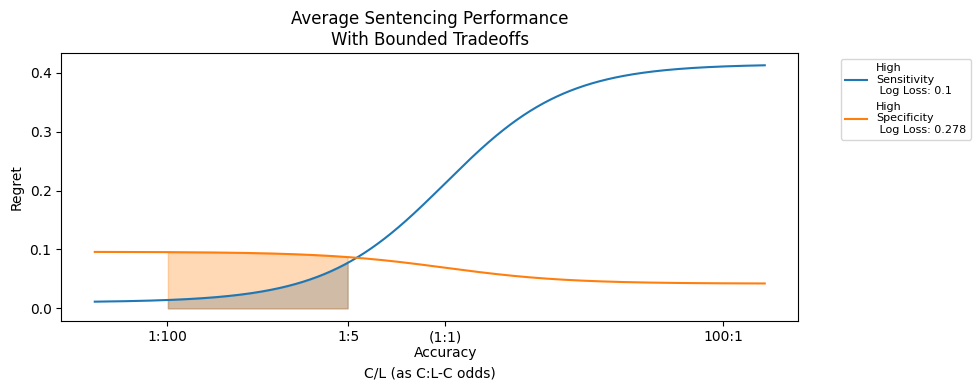

In [42]:
curve_comparison(
    model1=ClinicalPredictionModel.high_sensitivity_test,
    label1="High\nSensitivity\n",
    model2=ClinicalPredictionModel.high_specificity_test,
    label2="High\nSpecificity\n",
    scorer=LogLossScorer(),
    title="Average Sentencing Performance\nWith Bounded Tradeoffs",
    fill_min=1./101,
    ticks=[1.0 / 101, 1.0 / 6 ,1.0 / 2, 100./101]
) 

## Cancer Detection Performance Under Cost Heterogeneity

<Axes: title={'center': 'Cancer Detection Performance\nUnder Cost Heterogeneity'}, xlabel='C/L\n(Linear Scale)', ylabel='Regret'>

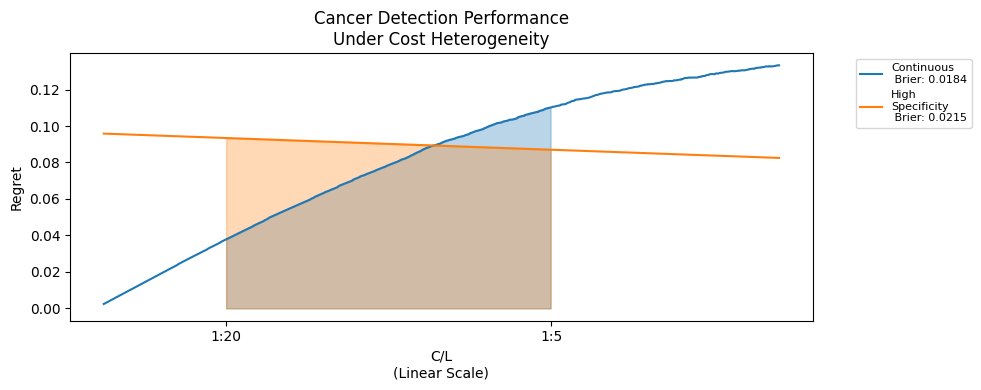

In [43]:
curve_comparison(
    model1=ClinicalPredictionModel.well_calibrated_model,
    label1="Continuous\n",
    model2=ClinicalPredictionModel.high_specificity_test,
    label2="High\nSpecificity\n",
    scorer=BrierScorer(),
    title="Cancer Detection Performance\nUnder Cost Heterogeneity",
    draw_max=0.25,
    ticks=[1.0/21, 1.0 / 6]
) 


## Cancer Detection Performance: Calibration Versus Discrimination

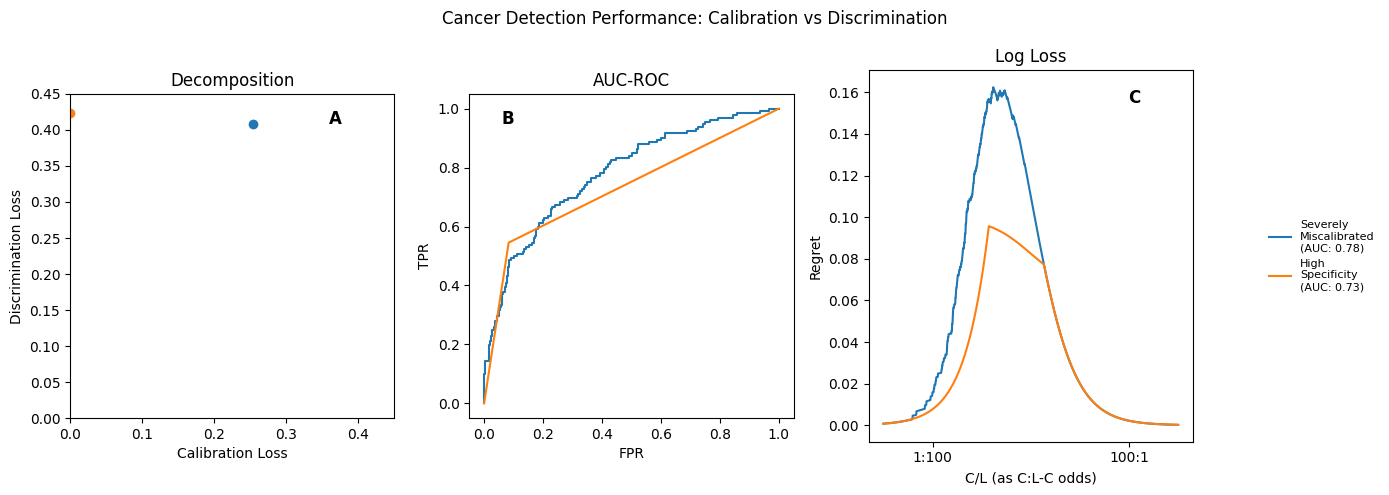

In [44]:
# Generate true disease status with 20% prevalence
n_patients = 600
prevalence = 0.20
y_true = generate_disease_status(n_patients=n_patients, prevalence=prevalence)

# Use severely miscalibrated model
y_pred_miscalibrated = ClinicalPredictionModel.severe_risk_underestimation_model(y_true)

# Use high specificity test model
y_pred_high_spec = ClinicalPredictionModel.calibrated_binary(y_true)

# Create scorers
brier_scorer = LogLossScorer()

# Changed to 1 row, 4 columns with specified width ratios
fig, axs = plt.subplots(1, 4, figsize=(14, 5), gridspec_kw={'width_ratios': [3, 3, 3, 1]})

# Plot log loss curves
plt.sca(axs[2])

# Add panel label C
axs[2].text(0.8, 0.95, 'C', transform=axs[2].transAxes, 
            fontsize=12, fontweight='bold', va='top')

draw_curve(y_true, y_pred_miscalibrated, scorer=brier_scorer, ticks=[1.0 / 101, 100./101])
draw_curve(y_true, y_pred_high_spec, scorer=brier_scorer, ticks=[1.0 / 101, 100./101])

# Plot ROC curves
plt.sca(axs[1])

# Add panel label B
axs[1].text(0.1, 0.95, 'B', transform=axs[1].transAxes, 
            fontsize=12, fontweight='bold', va='top')

# Severly miscalibrated model
fpr, tpr, _ = roc_curve(y_true, y_pred_miscalibrated)
auc = roc_auc_score(y_true, y_pred_miscalibrated)
plt.plot(fpr, tpr, label=f"Severely\nMiscalibrated\n(AUC: {auc:.2f})")

# High specificity test
fpr, tpr, _ = roc_curve(y_true, y_pred_high_spec)
auc = roc_auc_score(y_true, y_pred_high_spec)
plt.plot(fpr, tpr, label=f"High\nSpecificity\n(AUC: {auc:.2f})")

# Plot loss decomposition
plt.sca(axs[0])

# Add panel label A
axs[0].text(0.8, 0.95, 'A', transform=axs[0].transAxes, 
            fontsize=12, fontweight='bold', va='top')

# Severly miscalibrated model
calibration_loss, discrimination_loss = brier_scorer._partition_loss(y_true, y_pred_miscalibrated, brier_scorer.score)
plt.scatter(calibration_loss, discrimination_loss)

# High specificity test
calibration_loss, discrimination_loss = brier_scorer._partition_loss(y_true, y_pred_high_spec, brier_scorer.score)
plt.scatter(calibration_loss, discrimination_loss)

plt.sca(axs[2])
plt.ylabel("Regret")
plt.title("Log Loss")
plt.sca(axs[1])
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title("AUC-ROC")
plt.gca().set_aspect('equal', adjustable='box')
plt.sca(axs[0])
plt.xlabel("Calibration Loss")
plt.ylabel("Discrimination Loss")
plt.title("Decomposition")
plt.xlim([0, 0.45])
plt.ylim([0, 0.45])
plt.gca().set_aspect('equal', adjustable='box')

# Remove legends from the first three subplots and add to the fourth
for ax in axs[:3]:
    if ax.get_legend():
        ax.get_legend().remove()

# Get handles and labels from plot 1 (ROC plot)
handles, labels = axs[1].get_legend_handles_labels()
axs[3].legend(handles, labels, loc='center', fontsize=8, frameon=False)
axs[3].axis('off')  # Turn off axes for the fourth subplot

plt.suptitle("Cancer Detection Performance: Calibration vs Discrimination")
plt.tight_layout()



## Cancer Detection Performance: Decision Curves as H-Measures

<>:125: SyntaxWarning: invalid escape sequence '\p'
<>:125: SyntaxWarning: invalid escape sequence '\p'
/var/folders/8f/h3kcldy50kx99114fyyq93k00000gn/T/ipykernel_94701/2468817158.py:125: SyntaxWarning: invalid escape sequence '\p'
  plt.yticks([0, 0.2], "0 $\pi$".split())


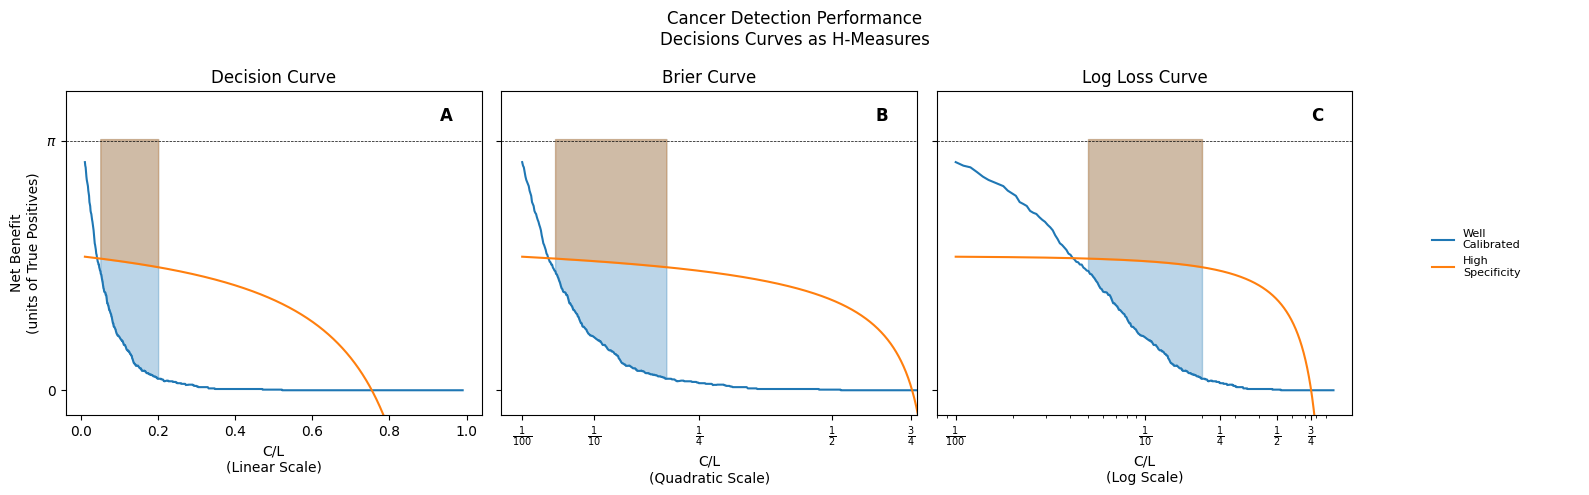

In [46]:
# Generate true disease status with 20% prevalence
n_patients = 2000
prevalence = 0.20
y_true = generate_disease_status(n_patients=n_patients, prevalence=prevalence)

# Get predictions from models
y_pred_high_spec = ClinicalPredictionModel.high_specificity_test(y_true)
y_pred_well_calibrated = ClinicalPredictionModel.severe_risk_underestimation_model(y_true)

# Create scorers
dca_scorer = DCAScorer()
brier_scorer = BrierScorer()
log_loss_scorer = LogLossScorer()

# Changed to 1 row, 4 columns with specified width ratios
fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharey=True, gridspec_kw={'width_ratios': [2, 2, 2, 1]})
axs[2].set_xscale("log")
scale_x_one_minus_one_minus_x_2(axs[1])

# Plot original DCA
plt.sca(axs[0])

# Add panel label A
axs[0].text(0.9, 0.95, 'A', transform=axs[0].transAxes, 
            fontsize=12, fontweight='bold', va='top')

draw_curve(
    y_true,
    y_pred_well_calibrated,
    scorer=dca_scorer,
    ticks=[1.0 / 101, 1.0 / 2],
    draw_range=[1e-2, 1 - 1e-2],
    fill_range=(0.05, 0.20),
    label="Well Calibrated"
)
draw_curve(
    y_true,
    y_pred_high_spec,
    scorer=dca_scorer,
    ticks=[1.0 / 101, 1.0 / 2],
    draw_range=[1e-2, 1 - 1e-2],
    fill_range=(0.05, 0.20),
    label="High Specificity"
)
plt.axhline(y=0.2, color="black", linestyle="--", lw=0.5, zorder=-10)

# Plot Brier Score
plt.sca(axs[1])

# Add panel label B
axs[1].text(0.9, 0.95, 'B', transform=axs[1].transAxes, 
            fontsize=12, fontweight='bold', va='top')

draw_curve(
    y_true,
    y_pred_well_calibrated,
    scorer=dca_scorer,
    ticks=[1.0 / 101, 1.0 / 2],
    draw_range=[1e-2, 1 - 1e-2],
    fill_range=(0.05, 0.20),
    label="Well Calibrated"
)
draw_curve(
    y_true,
    y_pred_high_spec,
    scorer=dca_scorer,
    ticks=[1.0 / 101, 1.0 / 2],
    draw_range=[1e-2, 1 - 1e-2],
    fill_range=(0.05, 0.20),
    label="High Specificity"
)
plt.axhline(y=0.2, color="black", linestyle="--", lw=0.5, zorder=-10)

# Plot Log Loss
plt.sca(axs[2])

# Add panel label C
axs[2].text(0.9, 0.95, 'C', transform=axs[2].transAxes, 
            fontsize=12, fontweight='bold', va='top')

draw_curve(
    y_true,
    y_pred_well_calibrated,
    scorer=dca_scorer,
    ticks=[1.0 / 101, 1.0 / 2],
    draw_range=[1e-2, 1 - 1e-2],
    fill_range=(0.05, 0.20),
    label="Well Calibrated"
)
draw_curve(
    y_true,
    y_pred_high_spec,
    scorer=dca_scorer,
    ticks=[1.0 / 101, 1.0 / 2],
    draw_range=[1e-2, 1 - 1e-2],
    fill_range=(0.05, 0.20),
    label="High Specificity"
)
plt.axhline(y=0.2, color="black", linestyle="--", lw=0.5, zorder=-10)

axs[0].set_ylabel("Net Benefit\n(units of True Positives)")
axs[1].set_ylabel("")
axs[2].set_ylabel("")
axs[0].set_title("Decision Curve")
axs[1].set_title("Brier Curve")
axs[2].set_title("Log Loss Curve")
axs[0].set_xlabel("C/L\n(Linear Scale)")
axs[1].set_xlabel("C/L\n(Quadratic Scale)")
axs[2].set_xlabel("C/L\n(Log Scale)")
axs[1].set_xticks(
    [0.01, 0.1, 0.25, 0.5, 0.75],
    r"$\frac{1}{100}$ $\frac{1}{10}$ $\frac{1}{4}$ $\frac{1}{2}$ $\frac{3}{4}$".split(),
)
axs[2].set_xticks(
    [0.01, 0.1, 0.25, 0.5, 0.75],
    r"$\frac{1}{100}$ $\frac{1}{10}$ $\frac{1}{4}$ $\frac{1}{2}$ $\frac{3}{4}$".split(),
)
for ax in axs[:3]:
    ax.get_legend().remove()
handles, labels = axs[0].get_legend_handles_labels()
axs[3].legend(handles, ["Well\nCalibrated", "High\nSpecificity"], loc='center', fontsize=8, frameon=False)
axs[3].axis('off')

plt.ylim([-.02, .24])
plt.yticks([0, 0.2], "0 $\pi$".split())
plt.suptitle("Cancer Detection Performance\nDecisions Curves as H-Measures")
plt.tight_layout()




## Priors over Thresholds

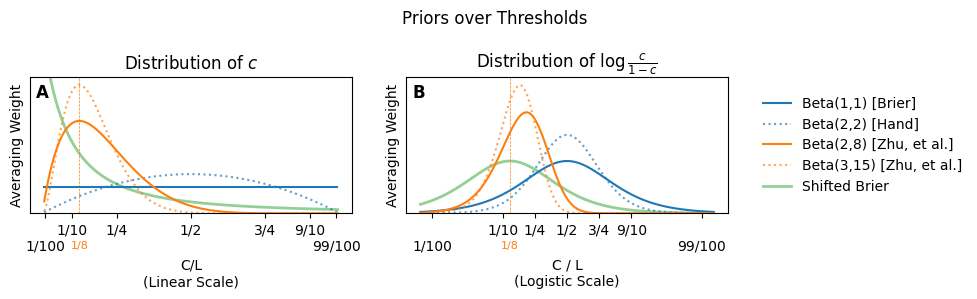

In [41]:
X_TICKS = [1.0 / 100, 1.0 / 10, 1.0 / 4.0, 1.0 / 2, 3.0 / 4, 9.0 / 10, 99.0 / 100]
X_TICK_LABELS = "\n1/100 1/10 1/4 1/2 3/4 9/10 \n99/100".split(" ")

z = np.linspace(-5, 5, 100)
x = scipy.special.expit(z)
one = x * 0 + 1
beta00 = one / x / (1 - x) / 40
beta22 = beta.pdf(x, 2, 2)
beta28 = beta.pdf(x, 2, 8)
beta315 = beta.pdf(x, 3, 15)
shifted = 7 / (7 * x + 1 * (1 - x)) ** 2
lower = np.minimum(one, beta00)

fig, axs = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'width_ratios': [2, 2, 1]})
plt.sca(axs[0])

# Add panel label A
axs[0].text(0.02, 0.95, 'A', transform=axs[0].transAxes, 
            fontsize=12, fontweight='bold', va='top')

color1 = plt.plot(x, one, label="Beta(1,1) [Brier]")[0].get_color()
plt.plot(x, beta22, label="Beta(2,2) [Hand]", linestyle=":", color=color1, alpha=0.7)
color4 = plt.plot(x, beta28, label="Beta(2,8) [Zhu, et al.]")[0].get_color()
plt.plot(x, beta315, label="Beta(3,15) [Zhu, et al.]", linestyle=":", color=color4, alpha=0.7)
color5 = plt.plot(
    x,
    shifted,
    label="Shifted Brier",
    alpha=0.5,
    linewidth=2,
    zorder=-10,
)[0].get_color()
plt.axvline(x=1 / 8, color=color4, linestyle="--", lw=0.5, zorder=-10)
plt.text(
    1 / 8,
    -1.25,
    "1/8",
    color=color4,
    fontsize=8,
    ha="center",
    va="center",
    rotation=0,
)
plt.ylim([0, 5.2])
plt.xlabel("C/L")
plt.xticks(X_TICKS, X_TICK_LABELS)
plt.yticks([])
plt.xlabel("C/L\n(Linear Scale)")
plt.title("Distribution of $c$")

plt.sca(axs[1])

# Add panel label B
axs[1].text(0.02, 0.95, 'B', transform=axs[1].transAxes, 
            fontsize=12, fontweight='bold', va='top')

w = x * (1 - x)
one = w
beta00 = x * 0 + 0.1
lower = np.minimum(one, beta00)
plt.plot(z, one, color=color1)
plt.plot(z, beta22 * w, color=color1, linestyle=":", alpha=0.7)
plt.plot(z, beta28 * w, color=color4)
plt.plot(z, beta315 * w, color=color4, linestyle=":", alpha=0.7)
plt.plot(
    z,
    shifted * w,
    color=color5,
    alpha=0.5,
    linewidth=2,
    zorder=-10,
)
plt.axvline(
    x=scipy.special.logit(1 / 8), color=color4, linestyle="--", lw=0.5, zorder=-10
)
plt.text(
    scipy.special.logit(1 / 8),
    -0.155,
    "1/8",
    color=color4,
    fontsize=8,
    ha="center",
    va="center",
    rotation=0,
)
plt.ylim([0, 0.65])
plt.xlabel("C / L\n(Logistic Scale)")
plt.xticks(scipy.special.logit(X_TICKS), X_TICK_LABELS)
plt.yticks([])
plt.title(r"Distribution of $\log \frac{c}{1-c}$")

handles, labels = axs[0].get_legend_handles_labels()
axs[2].legend(handles, labels, loc='center', frameon=False)
axs[2].axis('off')

for ax in axs[:2]:
    plt.sca(ax)
    plt.ylabel("Averaging Weight")
plt.suptitle("Priors over Thresholds")
plt.tight_layout()

## Two Ways of Thinking About Cost Distributions

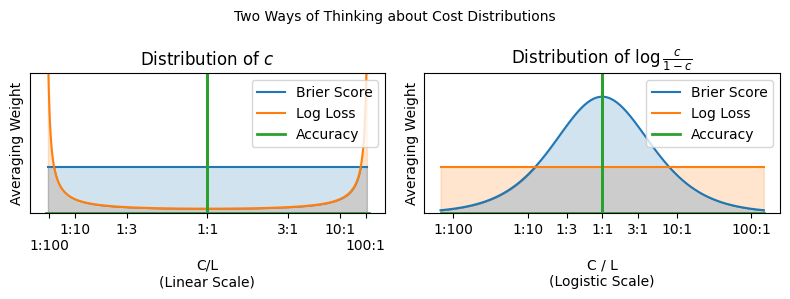

In [47]:
z = np.linspace(-5, 5, 100)
x = scipy.special.expit(z)
one = x * 0 + 1
beta00 = one / x / (1 - x) / 40
lower = np.minimum(one, beta00)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plt.rcParams['font.size'] = 10

color1 = axs[0].plot(x, one, label="Brier Score")[0].get_color()
color2 = axs[0].plot(x, beta00, label="Log Loss")[0].get_color()
axs[0].fill_between(x, one, lower, color=color1, alpha=0.2, zorder=-10)
axs[0].fill_between(x, beta00, lower, color=color2, alpha=0.2, zorder=-10)
axs[0].fill_between(x, one * 0, lower, color="black", alpha=0.2, zorder=-10)
color3 = axs[0].plot(
    [0, 0.5, 0.5, 0.5, 1],
    [0.01, 0.01, 3, 0.01, 0.01],
    label="Accuracy",
    linewidth=2,
)[0].get_color()
axs[0].set_ylim([0, 3])
axs[0].set_yticks([])
axs[0].set_xlabel("C/L\n(Linear Scale)")
axs[0].set_xticks(
    [1.0 / 101, 1.0 / 11, 1.0 / 4.0, 1.0 / 2, 3.0 / 4, 10.0 / 11, 100.0 / 101],
    "\n1:100 1:10 1:3 1:1 3:1 10:1 \n100:1".split(" "),
)
axs[0].legend(loc="upper right")
axs[0].set_title("Distribution of $c$")


w = x * (1 - x)
one = w
beta00 = x * 0 + 0.1
lower = np.minimum(one, beta00)

axs[1].plot(z, one, color=color1, label="Brier Score")
axs[1].plot(z, beta00, color=color2, label="Log Loss")
axs[1].fill_between(z, one, lower, color=color1, alpha=0.2, zorder=-10)
axs[1].fill_between(z, beta00, lower, color=color2, alpha=0.2, zorder=-10)
axs[1].fill_between(z, one * 0, lower, color="black", alpha=0.2, zorder=-10)
axs[1].plot(
    [-5, 0, 0, 0, 5],
    [0.001, 0.001, 2, 0.001, 0.001],
    color=color3,
    label="Accuracy",
    linewidth=2,
)
axs[1].set_ylim([0, 0.3])
axs[1].set_yticks([])
axs[1].set_xlabel("\nC / L\n(Logistic Scale)")
axs[1].set_xticks(
    scipy.special.logit(
        [1.0 / 101, 1.0 / 11, 1.0 / 4.0, 1.0 / 2, 3.0 / 4, 10.0 / 11, 100.0 / 101]
    ),
    "1:100 1:10 1:3 1:1 3:1 10:1 100:1".split(" "),
)
axs[1].legend(loc="upper right")
axs[1].set_title(r"Distribution of $\log \frac{c}{1-c}$")
for ax in axs:
    ax.set_ylabel("Averaging Weight")
    
plt.suptitle("Two Ways of Thinking about Cost Distributions", size=10)
plt.tight_layout()
